## For symmetry vesta phonopy 
drivelink
read dft books 2
## Found weights atomic and orbital dos weightage -- interface - DOS image + contribution of each - some sorta visuals
Image analysis 
Codes for Crystal structure analysis

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from pymatgen.io.vasp.outputs import Vasprun
from pymatgen.electronic_structure.core import Spin
import os
from pathlib import Path

In [60]:
# Set compound directory (change this to test different compounds)
compound_dir = r"C:\Users\AbCMS_Lab\Desktop\Keshav-DDP\Inverse-design\ZrCl2-dc09b7c396eb"
vasprun_path = os.path.join(compound_dir, "ss_2d%2FZrCl2-dc09b7c396eb%2Fbands_ncl%2Fvasprun.xml")

print(f"Processing: {compound_dir}")
print(f"Vasprun: {vasprun_path}")
print(f"File exists: {os.path.exists(vasprun_path)}")

Processing: C:\Users\AbCMS_Lab\Desktop\Keshav-DDP\Inverse-design\ZrCl2-dc09b7c396eb
Vasprun: C:\Users\AbCMS_Lab\Desktop\Keshav-DDP\Inverse-design\ZrCl2-dc09b7c396eb\ss_2d%2FZrCl2-dc09b7c396eb%2Fbands_ncl%2Fvasprun.xml
File exists: True


In [61]:
# Parse vasprun.xml
vr = Vasprun(vasprun_path, parse_dos=True, parse_eigen=False)
complete_dos = vr.complete_dos
structure = vr.final_structure

# Get Fermi energy
e_fermi = vr.efermi
print(f"Fermi Energy: {e_fermi:.4f} eV")

# Get VBM and CBM
vbm = complete_dos.get_cbm_vbm()[1]  # Returns (CBM, VBM)
cbm = complete_dos.get_cbm_vbm()[0]
print(f"VBM: {vbm:.4f} eV")
print(f"CBM: {cbm:.4f} eV")
print(f"Band Gap: {cbm - vbm:.4f} eV")

Fermi Energy: 0.1363 eV
VBM: 0.1090 eV
CBM: 0.5448 eV
Band Gap: 0.4359 eV


In [62]:
# Define windows (0.5 eV on each side)
# Shift VBM and CBM to Fermi-centered reference
vbm_shifted = vbm - e_fermi
cbm_shifted = cbm - e_fermi

vbm_window = [vbm_shifted - 0.5, vbm_shifted]
cbm_window = [cbm_shifted, cbm_shifted + 0.5]

print(f"VBM (shifted): {vbm_shifted:.4f} eV")
print(f"CBM (shifted): {cbm_shifted:.4f} eV")
print(f"VBM Window: [{vbm_window[0]:.4f}, {vbm_window[1]:.4f}] eV")
print(f"CBM Window: [{cbm_window[0]:.4f}, {cbm_window[1]:.4f}] eV")

# Get energy grid and total DOS
energies = complete_dos.energies - e_fermi  # Shift to Fermi = 0
# Sum both spin channels if available (for SOC calculations)
if Spin.down in complete_dos.densities:
    total_dos = complete_dos.densities[Spin.up] + complete_dos.densities[Spin.down]
    print("Using both spin channels (spin-polarized)")
else:
    total_dos = complete_dos.densities[Spin.up]
    print("Using single spin channel (non-spin-polarized)")

print(f"\nEnergy range: [{energies.min():.2f}, {energies.max():.2f}] eV")
print(f"Number of energy points: {len(energies)}")


VBM (shifted): -0.0273 eV
CBM (shifted): 0.4086 eV
VBM Window: [-0.5273, -0.0273] eV
CBM Window: [0.4086, 0.9086] eV
Using single spin channel (non-spin-polarized)

Energy range: [-52.98, 12.39] eV
Number of energy points: 301


In [63]:
# Get element and orbital projected DOS
from pymatgen.electronic_structure.core import OrbitalType

element_dos = complete_dos.get_element_dos()
print("\nElements in structure:")
for el in element_dos:
    print(f"  {el}")

# Function to integrate DOS in a window
def integrate_dos_window(energies, dos_values, window):
    """Integrate DOS within energy window using trapezoidal rule"""
    mask = (energies >= window[0]) & (energies <= window[1])
    e_window = energies[mask]
    dos_window = dos_values[mask]
    if len(e_window) < 2:
        return 0.0
    return np.trapezoid(dos_window, e_window)

# Calculate orbital contributions for each element
contributions = {}

# Map orbital names
orbital_map = {'s': OrbitalType.s, 'p': OrbitalType.p, 'd': OrbitalType.d}

for element in element_dos:
    el_name = str(element)
    contributions[el_name] = {}
    
    # Get orbital-projected DOS for this element
    spd_dos = complete_dos.get_element_spd_dos(element)
    
    for orbital_str in ['s', 'p', 'd']:
        orbital_type = orbital_map[orbital_str]
        if orbital_type in spd_dos:
            # Sum both spin channels if available
            if Spin.down in spd_dos[orbital_type].densities:
                orbital_dos = spd_dos[orbital_type].densities[Spin.up] + spd_dos[orbital_type].densities[Spin.down]
            else:
                orbital_dos = spd_dos[orbital_type].densities[Spin.up]
            
            # Integrate in VBM window
            vbm_integral = integrate_dos_window(energies, orbital_dos, vbm_window)
            
            # Integrate in CBM window
            cbm_integral = integrate_dos_window(energies, orbital_dos, cbm_window)
            
            contributions[el_name][orbital_str] = {
                'VBM': vbm_integral,
                'CBM': cbm_integral
            }
        else:
            contributions[el_name][orbital_str] = {'VBM': 0.0, 'CBM': 0.0}

print("\nRaw contributions (integrated DOS):")
for el in contributions:
    print(f"\n{el}:")
    for orb in ['s', 'p', 'd']:
        vbm_val = contributions[el][orb]['VBM']
        cbm_val = contributions[el][orb]['CBM']
        print(f"  {orb}: VBM={vbm_val:.4f}, CBM={cbm_val:.4f}")


Elements in structure:
  Zr
  Cl

Raw contributions (integrated DOS):

Zr:
  s: VBM=0.0002, CBM=0.0002
  p: VBM=0.0028, CBM=0.0004
  d: VBM=0.0690, CBM=0.2712

Cl:
  s: VBM=0.0000, CBM=0.0007
  p: VBM=0.0087, CBM=0.0602
  d: VBM=0.0000, CBM=0.0000


In [64]:
# Debug: Check what's in element DOS
print("Debugging element DOS:")
for element in element_dos:
    print(f"\nElement: {element}")
    # Sum both spin channels if available
    if Spin.down in element_dos[element].densities:
        el_dos_val = element_dos[element].densities[Spin.up] + element_dos[element].densities[Spin.down]
    else:
        el_dos_val = element_dos[element].densities[Spin.up]
    print(f"  DOS shape: {el_dos_val.shape}")
    print(f"  DOS min: {el_dos_val.min():.4f}, max: {el_dos_val.max():.4f}")
    print(f"  DOS sum: {el_dos_val.sum():.4f}")
    
    # Check SPD DOS
    spd = complete_dos.get_element_spd_dos(element)
    print(f"  Available orbitals: {list(spd.keys())}")
    for orb in spd:
        # Sum both spin channels if available
        if Spin.down in spd[orb].densities:
            orb_dos = spd[orb].densities[Spin.up] + spd[orb].densities[Spin.down]
        else:
            orb_dos = spd[orb].densities[Spin.up]
        print(f"    {orb}: min={orb_dos.min():.4f}, max={orb_dos.max():.4f}, sum={orb_dos.sum():.4f}")

Debugging element DOS:

Element: Zr
  DOS shape: (301,)
  DOS min: 0.0000, max: 10.4139
  DOS sum: 75.3019
  Available orbitals: [<OrbitalType.s: 0>, <OrbitalType.p: 1>, <OrbitalType.d: 2>]
    s: min=0.0000, max=8.0685, sum=12.1200
    p: min=0.0000, max=10.4127, sum=28.5508
    d: min=0.0000, max=3.8604, sum=34.6311

Element: Cl
  DOS shape: (301,)
  DOS min: 0.0000, max: 6.6164
  DOS sum: 55.5009
  Available orbitals: [<OrbitalType.s: 0>, <OrbitalType.p: 1>, <OrbitalType.d: 2>]
    s: min=0.0000, max=6.5962, sum=16.1514
    p: min=0.0000, max=5.2404, sum=39.3495
    d: min=0.0000, max=0.0000, sum=0.0000


In [65]:
# Normalize contributions
def normalize_contributions(contributions):
    """Normalize contributions to sum to 1 (100%)"""
    normalized = {}
    
    # Calculate total for VBM and CBM separately
    total_vbm = sum(
        contributions[el][orb]['VBM'] 
        for el in contributions 
        for orb in ['s', 'p', 'd']
    )
    total_cbm = sum(
        contributions[el][orb]['CBM'] 
        for el in contributions 
        for orb in ['s', 'p', 'd']
    )
    
    # Normalize
    for el in contributions:
        normalized[el] = {}
        for orb in ['s', 'p', 'd']:
            normalized[el][orb] = {
                'VBM': contributions[el][orb]['VBM'] / total_vbm if total_vbm > 0 else 0,
                'CBM': contributions[el][orb]['CBM'] / total_cbm if total_cbm > 0 else 0
            }
    
    return normalized, total_vbm, total_cbm

normalized_contrib, total_vbm, total_cbm = normalize_contributions(contributions)

print(f"\nTotal integrated DOS in VBM window: {total_vbm:.4f}")
print(f"Total integrated DOS in CBM window: {total_cbm:.4f}")

print("\n\nNormalized weights (percentages):")
for el in normalized_contrib:
    print(f"\n{el}:")
    for orb in ['s', 'p', 'd']:
        vbm_weight = normalized_contrib[el][orb]['VBM'] * 100
        cbm_weight = normalized_contrib[el][orb]['CBM'] * 100
        print(f"  {orb}: VBM={vbm_weight:.2f}%, CBM={cbm_weight:.2f}%")


Total integrated DOS in VBM window: 0.0806
Total integrated DOS in CBM window: 0.3326


Normalized weights (percentages):

Zr:
  s: VBM=0.23%, CBM=0.05%
  p: VBM=3.47%, CBM=0.12%
  d: VBM=85.54%, CBM=81.51%

Cl:
  s: VBM=0.00%, CBM=0.22%
  p: VBM=10.76%, CBM=18.11%
  d: VBM=0.00%, CBM=0.00%


In [66]:
# Calculate atomic (element) contributions (sum over orbitals)
atomic_weights = {}
for el in normalized_contrib:
    vbm_total = sum(normalized_contrib[el][orb]['VBM'] for orb in ['s', 'p', 'd'])
    cbm_total = sum(normalized_contrib[el][orb]['CBM'] for orb in ['s', 'p', 'd'])
    atomic_weights[el] = {'VBM': vbm_total * 100, 'CBM': cbm_total * 100}

print("\nAtomic (Element) Contributions:")
for el in atomic_weights:
    print(f"  {el}: VBM={atomic_weights[el]['VBM']:.2f}%, CBM={atomic_weights[el]['CBM']:.2f}%")

# Calculate orbital contributions (sum over elements)
orbital_weights = {'s': {'VBM': 0, 'CBM': 0}, 'p': {'VBM': 0, 'CBM': 0}, 'd': {'VBM': 0, 'CBM': 0}}
for orb in ['s', 'p', 'd']:
    vbm_total = sum(normalized_contrib[el][orb]['VBM'] for el in normalized_contrib)
    cbm_total = sum(normalized_contrib[el][orb]['CBM'] for el in normalized_contrib)
    orbital_weights[orb] = {'VBM': vbm_total * 100, 'CBM': cbm_total * 100}

print("\nOrbital Contributions:")
for orb in ['s', 'p', 'd']:
    print(f"  {orb}: VBM={orbital_weights[orb]['VBM']:.2f}%, CBM={orbital_weights[orb]['CBM']:.2f}%")


Atomic (Element) Contributions:
  Zr: VBM=89.24%, CBM=81.68%
  Cl: VBM=10.76%, CBM=18.32%

Orbital Contributions:
  s: VBM=0.23%, CBM=0.26%
  p: VBM=14.23%, CBM=18.22%
  d: VBM=85.54%, CBM=81.51%


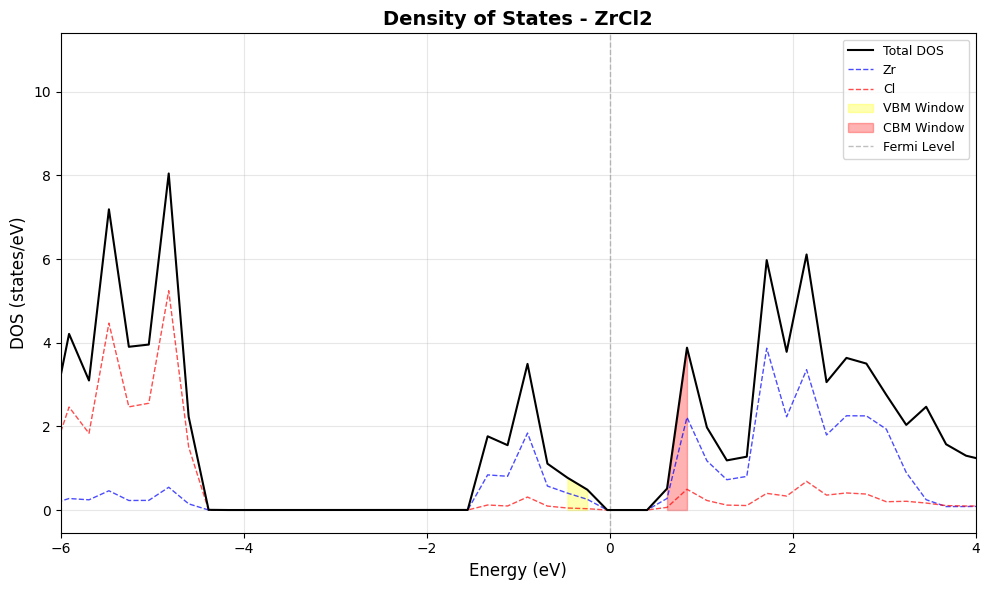


Plot generated for ZrCl2


In [67]:
# Plot DOS with highlighted VBM and CBM windows
fig, ax = plt.subplots(figsize=(10, 6))

# Plot total DOS
ax.plot(energies, total_dos, 'k-', linewidth=1.5, label='Total DOS', zorder=3)

# Plot element-projected DOS
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown']
for i, element in enumerate(element_dos):
    # Sum both spin channels if available
    if Spin.down in element_dos[element].densities:
        el_dos = element_dos[element].densities[Spin.up] + element_dos[element].densities[Spin.down]
    else:
        el_dos = element_dos[element].densities[Spin.up]
    ax.plot(energies, el_dos, linestyle='--', linewidth=1, 
            color=colors[i % len(colors)], label=str(element), alpha=0.7, zorder=2)

# Highlight VBM window (energies are already shifted to Fermi = 0)
vbm_mask = (energies >= vbm_window[0]) & (energies <= vbm_window[1])
ax.fill_between(energies[vbm_mask], 0, total_dos[vbm_mask], 
                alpha=0.3, color='yellow', label='VBM Window', zorder=1)

# Highlight CBM window
cbm_mask = (energies >= cbm_window[0]) & (energies <= cbm_window[1])
ax.fill_between(energies[cbm_mask], 0, total_dos[cbm_mask], 
                alpha=0.3, color='red', label='CBM Window', zorder=1)

# Vertical line at Fermi level (0 after shift)
ax.axvline(x=0, color='gray', linestyle='--', linewidth=1, alpha=0.5, label='Fermi Level')

# Labels and formatting
ax.set_xlabel('Energy (eV)', fontsize=12)
ax.set_ylabel('DOS (states/eV)', fontsize=12)
compound_name = os.path.basename(compound_dir).split('-')[0]
ax.set_title(f'Density of States - {compound_name}', fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=9)
ax.set_xlim([-6, 4])
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nPlot generated for {compound_name}")


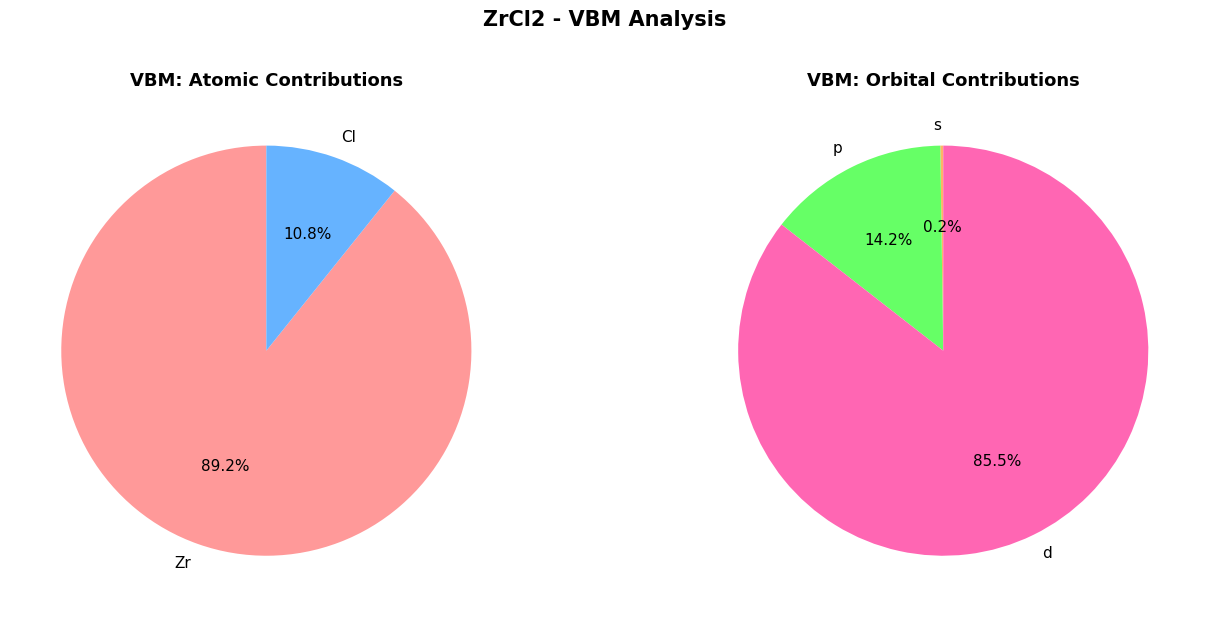

In [68]:
# Create pie charts for VBM contributions
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# VBM Atomic Contributions
ax1 = axes[0]
atomic_labels = list(atomic_weights.keys())
atomic_vbm_values = [atomic_weights[el]['VBM'] for el in atomic_labels]
colors_atomic = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#ff99cc']
wedges1, texts1, autotexts1 = ax1.pie(
    atomic_vbm_values, 
    labels=atomic_labels, 
    autopct='%1.1f%%',
    colors=colors_atomic[:len(atomic_labels)],
    startangle=90,
    textprops={'fontsize': 11}
)
ax1.set_title('VBM: Atomic Contributions', fontsize=13, fontweight='bold')

# VBM Orbital Contributions
ax2 = axes[1]
orbital_labels = ['s', 'p', 'd']
orbital_vbm_values = [orbital_weights[orb]['VBM'] for orb in orbital_labels]
colors_orbital = ['#ffb366', '#66ff66', '#ff66b3']
wedges2, texts2, autotexts2 = ax2.pie(
    orbital_vbm_values, 
    labels=orbital_labels, 
    autopct='%1.1f%%',
    colors=colors_orbital,
    startangle=90,
    textprops={'fontsize': 11}
)
ax2.set_title('VBM: Orbital Contributions', fontsize=13, fontweight='bold')

plt.suptitle(f'{compound_name} - VBM Analysis', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

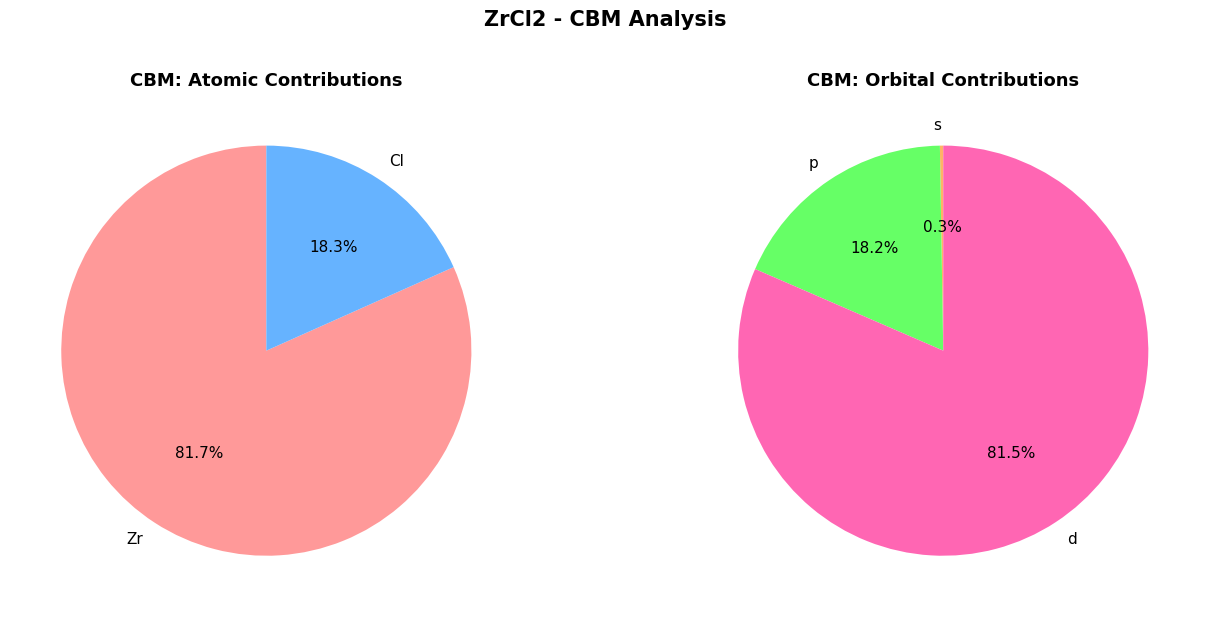

In [69]:
# Create pie charts for CBM contributions
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# CBM Atomic Contributions
ax1 = axes[0]
atomic_cbm_values = [atomic_weights[el]['CBM'] for el in atomic_labels]
wedges1, texts1, autotexts1 = ax1.pie(
    atomic_cbm_values, 
    labels=atomic_labels, 
    autopct='%1.1f%%',
    colors=colors_atomic[:len(atomic_labels)],
    startangle=90,
    textprops={'fontsize': 11}
)
ax1.set_title('CBM: Atomic Contributions', fontsize=13, fontweight='bold')

# CBM Orbital Contributions
ax2 = axes[1]
orbital_cbm_values = [orbital_weights[orb]['CBM'] for orb in orbital_labels]
wedges2, texts2, autotexts2 = ax2.pie(
    orbital_cbm_values, 
    labels=orbital_labels, 
    autopct='%1.1f%%',
    colors=colors_orbital,
    startangle=90,
    textprops={'fontsize': 11}
)
ax2.set_title('CBM: Orbital Contributions', fontsize=13, fontweight='bold')

plt.suptitle(f'{compound_name} - CBM Analysis', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()